# Stance Classification of Tweets using Transfer Learning
This notebook shows how *transfer learning*, an extension of deep learning, can be used for predicting Tweet stance toward a particular topic.

# 1. Motivation

The traditional approach to applying deep learning methods in NLP have involved feeding a model large amounts of labeled training data, and fitting the model's parameters to this data. In practice, natural language data is highly variable and can come in a variety of forms (tweets, blog posts, reviews etc.), and hence, a model trained for a particular language task does not generalize well to new data from another distribution. In addition, many natural language applications do not come with an abundance of labeled examples, and human annotation can get very expensive as the datasets get larger.

This offers good motivation to explore the notion of [transfer learning](http://ruder.io/transfer-learning/index.html#whatistransferlearning) - a machine-learning technique that has the ability to transfer knowledge to novel scenarios not encountered during training. While transfer learning has been ubiquitous throughout computer vision applications since the advent of huge datasets such as ImageNet, it is only since 2017-18 that significant progress has been made for transfer learning in NLP applications. There have been a string of interesting papers in 2018 that discuss the power of language models in natural language understanding and how they can be used to provide pre-trained representations of a language's syntax, which can be far more useful when training a neural network for previously unseen tasks.

Twitter data is a very interesting use case for transfer learning, mainly because the typical language syntax seen in Tweets is quite different from that which is used to train language models. For these reasons, the **2016 SemEval Stance Detection task** is chosen for studying the effectiveness of our transfer learning approach. The dataset, experiments and the evaluation criteria used are explained in below sections. 

The aim of this notebook is to highlight the development of a model that can help answer the following questions:
- How does our approach generalize to Twitter-specific language syntax?
- Are we able to achieve reasonable results (comparable to the winning team of SemEval 2016 Task 6) with *limited amounts of training data* and *limited computing resources*?
- How much fine-tuning effort is required to achieve reasonable results?

# 2. Approach
This section describes the 3-Layer LSTM architecture used for transfer learning, **ULMFit**. This is the architecture described in the well known paper by [Howard and Ruder, 2018](https://arxiv.org/pdf/1801.06146.pdf), that has been proven to generalize
well to unseen distributions. The goal is to see how *ULMFit* can perform in this particular Tweet stance classification task.


## 2.1 ULMFit Model Architecture
![title](assets/ulmfit_arch.png)

Source: [Howard and Ruder, 2018](https://arxiv.org/pdf/1801.06146.pdf)

To classify out-of-domain data (such as our Twitter data), the following techniques are applied from the ULMFit paper:

### Discriminative Fine-tuning
From the *ULMFit* paper, each layer of the model captures *different types of information*. Hence, it makes sense to fine-tune each layer differently, and this is done in *ULMFit* after extensive empirical testing and implementation updates. Rather than change each layer manually, we can use the implemented ratios, but adapt the multiplier that influences the learning rate for each layer. 

*ULMFit* also uses discriminative fine-tuning with regard to the SGD update as follows:

$\theta_{t}^{l} = \theta_{t-1}^{l} - \eta^{l} \cdot \nabla_{\theta^l} J{\theta} $

### 1-cycle learning rate policy
In the fine-tuning stage, a *1-cycle learning rate* policy is applied, which comes from this [report by Leslie Smith](https://arxiv.org/abs/1803.09820). It is a modification of the cyclical learning rate policy, which has been around for a long time, but the 1-cycle policy allows a large initial learning rate ($LR_{max}=10^{-3}$, for example), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. In the ULMFit implementation,  this 1-cycle policy has been tweaked and is referred to as *slanted triangular learning rate*.

### Gradual unfreezing
Rather than training all the layers at once during classification, the layers are "frozen" and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as *catastrophic forgetting* (by fine-tuning all layers too aggressively). 

### Concatenated pooling
Because an input text can consist of hundreds or thousands of words, information might get lost if we only consider the last hidden state.

Hence, the hidden state at the last time step, $h_T$ is concatenated with *both* the max-pooled and mean-pooled representation of the hidden states over as many time steps as can fit in GPU memory.

$h_C = [h_T, maxpool(H), meanpool(H)]$

Where $H$ is the vector of all hidden states.

### 3-stage fine-tuning methodology
The classification task is done in a 3-stage process:
1. General-domain LM pretraining: ULMFit has a pretrained model generated using an AWD-LSTM (as per [Merity et al., 2017]((https://arxiv.org/pdf/1708.02182.pdf))) to develop a language model called ```Wikitext-103``` and was trained of 28,595 preprocessed Wikipedia articles, totalling to 103 million words. 
2. Target task *LM* fine-tuning: Since the data for the target will likely come from a different distribution, ULMFit allows us to use the pre-trained language model anf fine-tune it (using the above techniques) to adapt to the idiosyncrasies of the target data.
3. Target task *classifier* fine-tuning: Once we save the updated weights from the language model fine-tuning step, we can fine-tune the classifier with gradual unfreezing and the other techniques described above to perform  task-specific class prediction. 

Note that for this SemEval Tweet stance classification task, we only perform steps 2 and 3, and utilize the pretrained language model from the ```fastai``` database. 

# 3. Data

The training and test data consist of Tweets pertaining to five distinct topics, shown in [SemEval 2016: Task 6](http://alt.qcri.org/semeval2016/task6/). We only look at Task A: "Supervised Framework" in this notebook. The train and test data (including the gold) are in the the ```data/``` directory provided along with this repository.

The five topics for which Tweets are provided as part of the training data are given below. 

| Topic        
|:------------ | 
| Atheism     |
| Climate Change is a Real Concern  | 
| Feminist Movement | 
| Hillary Clinton  |
| Legalization of Abortion  | 

A more detailed breakdown of the tweets for this shared task is provided in [this link](http://www.saifmohammad.com/WebPages/StanceDataset.htm). 

## Size of dataset
The total number of Tweets (in the training set) available for this task is roughly 2700, which amounts to roughly 500-600 Tweets per topic. Thus, this can be considered a small dataset. 

![title](assets/stance_balance.png)

Upon inspecting the training data, it is clear that there is quite a large variance in terms of the number of Tweets in favor vs. those against a topic. There is quite a large variance *within* classes as well as *between* classes in the overall data. 

## 3.1 Pretrained language models

*ULMFit* uses its own pretrained language model ```wikitext-103``` that can be conveniently downloaded  from the ```fastai``` database hosted on AWS. 


## 3.2 Preprocess SemEval training data
This section discusses the steps used to prepare the data for transfer learning utilizing the ```fastai``` framework. In particular, the ```fastai.text``` library is designed to work very well with tabular data, hence, Pandas DataFrames are used to organize and filter the data.

In [2]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

### Define the path to train and test data for SemEval 2016 Task 6
The full data and evaluation files for this task is available on the [source page](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools). However, these have been included along with this repository for future reference. 

In [3]:
path = Path('./data')
trainfile = 'semeval2016-task6-trainingdata.txt'
testfile = 'SemEval2016-Task6-subtaskA-testdata.txt'

Some of the characters in the training set are not *utf-8* encoded, hence we make sure that we only treat the characters that appear in the English language for this task.

In [4]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [5]:
train_orig = pd.read_csv(path/trainfile, delimiter='\t', header=0, encoding = "latin-1")

In [6]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.1.0


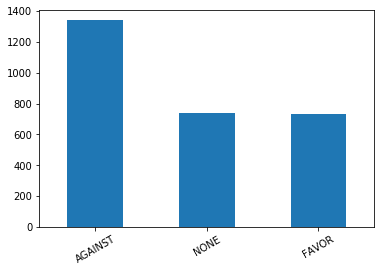

In [7]:
# Plot value counts for rach stance in the dataset
train_orig['Stance'].value_counts().plot.bar(rot=30);

In [8]:
print("SemEval 2016 Task 6 (subtask A) Tweet topics are:\n")
print("------------------------------------------")
for item in train_orig['Target'].unique():
    print(item)

SemEval 2016 Task 6 (subtask A) Tweet topics are:

------------------------------------------
Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


### Apply the cleaning function to the 'Tweet' column of the training data

In [9]:
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)

In [10]:
train_orig.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


### Store the relevant information from training data 
ULMFit requires just the stance and the text data (i.e. tweets) for the language-model finetuning and classification steps, hence these are stored in a DataFrame.

In [11]:
train = pd.concat([train_orig['Stance'], train_orig['Tweet']], axis=1)
train.tail()

,Stance,Tweet
2809,AGAINST,"There's a law protecting unborn eagles, but no..."
2810,AGAINST,I am 1 in 3... I have had an abortion #Abortio...
2811,AGAINST,How dare you say my sexual preference is a cho...
2812,AGAINST,"Equal rights for those 'born that way', no rig..."
2813,AGAINST,#POTUS seals his legacy w/ 1/2 doz wins. The #...


In [12]:
# Write train to csv
train.to_csv(path/'train.csv', index=False, header=False)

# 4. Experimental Setup

Stance detection uses a *semi-supervised approach* where we reuse weights from a pretrained language model (in this case ```wikitext-103```) and perform multi-class classification on the training data over the three classes (*FAVOR*, *AGAINST* and *NONE*).

### Evaluation
The metric used to score the stance classification is **F-score**. The event organizers provide an [evaluation script](http://alt.qcri.org/semeval2016/task6/index.php?id=data-and-tools) that calculates the macro-average of F-score (FAVOR) and F-score (AGAINST) for task A. This compares our model's predicted stance for each Tweet against the gold reference.

The *perl* script provided by the organizers is used to generate an F- score. The evaluation script is in ```data/eval/``` and has the following usage:
    
    cd data/eval
    perl eval.pl -u

    ---------------------------
    Usage:
    perl eval.pl goldFile guessFile

    goldFile:  file containing gold standards;
    guessFile: file containing your prediction.

### Reference result
To have a benchmark to compare our results against, it makes sense to look at the winning paper for this shared task, from team *MITRE*, who [published their methodology and approach](https://arxiv.org/pdf/1606.03784.pdf). From this paper, it can be seen that *MITRE* used an LSTM-based deep learning approach and performed per-topic classification of Tweets to achieve an average macro F-score of **0.67**. 

### Stance Prediction
The predicted output stances on the test dataset is written out according to the format expected by the evaluation *perl* script, and the F-scores are published as per this evaluation.

# 5. Transfer Learning Stages

This notebook utilizes the refactored and updated version (```v1```) of *ULMFit* as implemented in the [fastai](https://github.com/fastai/fastai/tree/master/fastai)  GitHub repository. This requires an install of **Pytorch 1.0.0** ([released on December 7, 2018](https://developers.facebook.com/blog/post/2018/05/02/announcing-pytorch-1.0-for-research-production/)) to run since its development intended to move alongside PyTorch's own development cycle in the future. It is recommended to run this entire notebook in a virtual environment to avoid clashes with pre-existing installs of PyTorch.

The refactored code for *ULMFit* is much more high-level and abstracted than the original version that was used in the paper, so it doesn't make sense to rewrite the data manipulation code for text handling and tokenization from the ground up. We can take advantage of the powerful transfer learning functionality that is baked into ULMFit (obtained after months of fine-tuning and refactoring the source code by Fast.ai) instead! 

## 5.1 Language model finetuning: (SemEval Tweets only)
The pre-trained language model used is from [this work by Merity et al.](https://arxiv.org/pdf/1708.02182.pdf). Although we are working with Twitter whose content's structure that can be quite dissimilar to Wikipedia's sentence formulation, the hope is that the language understanding developed by the model, in combination with the fine-tuning techniques described in [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf), will allow us to at least transfer some knowledge for the purposes of classification of Tweet stance.

### Preprocess data for language model fine-tuning
The ```TextLMDataBunch```[ [source]](https://docs.fast.ai/text.data.html#TextLMDataBunch) class returns a "Databunch" type of object that is a custom object defined in fastai.text's API. Note that according to this class definition, a significant amount of data pre-processing is going on under the hood. 

- Initialize the language model with the pre-trained vocabulary's weights
- Create a custom data loader that "batchifies" the target task's vocabulary, i.e. split it up into batches for processing on the GPU
- Introduce randomness into the batches, but without breaking up the sentence sequences using techniques [borrowed from language modeling](https://arxiv.org/pdf/1708.02182.pdf).
- Tokenize the target task's vocabulary and increase the efficiency of tokenization (for large tasks) using multi-threading
 

In [13]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', min_freq=1)

Note that in this case, we specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag ```<unk>``` during tokenization.

In [14]:
# Save the language and classifier model data for re-use
data_lm.save()

In [15]:
# # Reload LM and clas data from file if doing so for large cases
# data_lm = TextLMDataBunch.load(path)
# data_clas = TextClasDataBunch.load(path, bs=32)

In [16]:
data_lm.show_batch()

idx,text
0,the rise of # semst xxbos i brace myself for the onslaught anytime i walk by any man on the street . # catcalling # streetharassment # equality # sexism # semst xxbos u xxmaj missouri at xxup kc got xxmaj chelsea caus xxmaj hils cost too much . xxmaj chels could arrive w / mom - no xtra charge . @hillaryclinton # semst xxbos @pennyred is the xxup uk
1,times the number of ppl xxmaj hitler is considered responsible for killing # semst xxbos @spectator exactly women are so weak and incapable the sight of one in a slim skin is giving them an attack of the vapours # semst xxbos @ricky_vaughn99 xxmaj why is it called history and not herstory ? ! # semst xxbos @shalomshuli i 'm guessing there was a lot less humidity back in the
2,"follows that there must be a means of carrying it out . # semst xxbos xxmaj when it comes to scientific discoveries , the # religious call them bullshit until their texts already knew it . # semst xxbos 3 . xxmaj fixing xxmaj america 's political system by getting rid of "" unaccountable "" money , and 4 . xxmaj protecting the country . # semst xxbos xxmaj want"
3,# semst xxbos xxmaj upload sexually provocative pics up for all to see . xxmaj but if someone you are n't attracted to looks it 's harassment ? xxmaj right # semst xxbos its gon na be worth it . its gon na work out . # semst xxbos @attenborough_d states the media needs to promote the damage of climate change . xxmaj how bout you # xxmaj bolt ?
4,of the xxup lord . xxmaj from the house of the xxup lord we bless you . xxmaj psalm 118:26 # semst xxbos _ anavgjoe _ : xxup rt ruth_blane : bansalsatnam : xxup rt ruth_blane : reversedowry : xxup rt ruth_blane : manojmane : xxmaj take this ! ! # xxmaj feminazi # scrap498a ... # semst xxbos @droakley1689 @phxapologetics xxmaj maybe they just misused their resources and their


We only need to run the above tokenization step once, and save the data. All the data goes to a local folder named ```tmp/```. For a large added vocabulary, the above tokenization step can take a while, hence we save them and restart the notebook from the next cell (if we close our session).

The tokenization technique used by ```fastai.text``` is quite advanced, and uses quite a few tricks to capture semantic meaning from the text. Unlike typical NLTK-type tokenization, here we are not converting the Tweets to lowercase and removing information from the base text - that would result in a tremendous loss of information that our model could use to gather an understanding of our new task's vocabulary.

Instead, a number of added tokens are applied so that minimal information is lost. A full list of all the tokenization rules used are [here](https://docs.fast.ai/text.transform.html#Rules). 

As an example, the ```xxmaj``` token [[source]](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/transform.py#L71) indicates that there is capitalization of the word, either in part or in full. "The" will be tokenized as "xxmaj the". For words that are full capitalized, such as "I AM SHOUTING"; it is tokenized as "xxup i xxup am xxup shouting". The tokenizer uses spaCy's underlying tokens, but adds tags in a very smart way that balances capturing semantic meaning while reducing the number of overall tokens, so it is both powerful and efficient. 

The tokenization process described above is highly efficient, in part thanks to the power of *SpaCy* and also due to the multi-threading wrappers implemented by Fast.ai on top of Spacy's tokenizer. As a result, a really large language model's vocabulary (of millions of words) can also be effectively tokenized in a reasonable time. 

### Define learner object for language model finetuning
We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and feed it a pre-trained language model. 

We use the ```wt_103_v1``` model that was refined after re-training using the more efficient ```fastai v1``` library. The data (```lstm_wt103.pth```) is downloaded through an AWS-hosted link (accessed through the ```fastai.datasets``` interface), and stored locally. All the data in the language model file is numericalized and stored in a way that the learner can efficiently pick up tokens in float form. In addition to the language model, there is also an additional pickle object ```itos_wt103.pkl``` that is similar to the ```torchtext``` definition of "integer-to-string" - this contains the list of unique tokens in word form, so that we can map the tokens back to strings if necessary.

In [18]:
URLs


fastai.datasets.URLs

In [30]:
# 2019-06-18: apparently, the URLs.WT103_1 is no more. Instead, interwebz suggest to use AWD_LSTM, e.g., https://www.kaggle.com/atul2926/fast-ai-v3-lesson-3-imdb-d8de15/log
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.1)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

### Print the structure of the language model RNN 
We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined  that updates the weights once we pass the input through the network.

In [31]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(8016, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(8016, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=8016, bias=True)
   (output_dp): RNNDropout()
 )]

### Find the optimum learning rate 
```fastai.train``` [source](https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23) provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset. 

The idea is that our optimization function needs to use a learning rate that is an order of magnitude below the point at which the loss starts to diverge. We can quickly find this as shown below. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


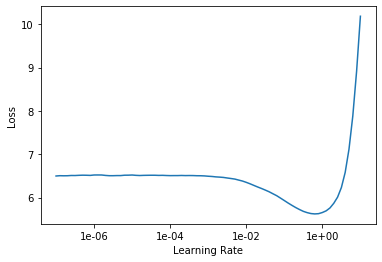

In [32]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

### Run the ```language_model_learner``` class
The pre-trained language model quickly downloads from the ```fastai```'s AWS link, so there is no need to download it separately. [```drop_mult```] is the multiplier applied to the dropout in the language learner. As per the ULMFit paper, we use a custom dropout for each language model layer, and the ```drop_mult```just scales a [numpy array of these dropouts](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/learner.py#L15) which remain in the same relative ratio to one another. These numbers have been obtained through empirical tuning for a range of language tasks, and we took note of this during our extensive reading on this task.

In [33]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.502666,5.591586,0.172154,00:01


### Unfreeze the entire model 
To train the language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss. For a larger target vocabulary, these hyperparameters might need to be modified, and teh training time would be significantly longer, but for this SemEval task, we have a very small additional vocabulary to fine-tune the language model on, so it is really quick.


In [34]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.908918,4.729880,0.232366,00:01
1,5.551603,4.580304,0.242076,00:01
2,5.293430,4.520673,0.261384,00:01
3,5.084409,4.502635,0.274442,00:01
4,4.911599,4.442494,0.277902,00:01
5,4.685530,4.317820,0.310714,00:01
6,4.426057,4.264633,0.310547,00:01
7,4.169012,4.287807,0.312946,00:01
8,3.912676,4.349275,0.310937,00:01
9,3.651563,4.441722,0.311551,00:01


In [35]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

## 5.2 Train the Classifier: SemEval Tweets only

For classification, the [winning paper for the SemEval 2016](https://www.aclweb.org/anthology/S/S16/S16-1074.pdf) task (team MITRE) describe in section $5$ of their paper that they achieved their highest average F1 score when they trained 5 *distinct* classifiers, i.e. a separate training task for each of the 5 topics in the training data. 

Hence, in this notebook we only perform classification for one *topic* at a time. Evaluation of the predicted classes is also done on a per-topic basis. 

### Identify the 5 topics in our training data

In [36]:
for item in train_orig.Target.unique():
    print(item)

Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


### Specify the topic we want to classify for
We specify the topic name exactly as the training data does, and use it to subset the Pandas DataFrame.

In [37]:
topic = "Feminist Movement"

In [38]:
# Get only those tweets that pertain to a single topic in the training data
train_topic = train.loc[train_orig['Target'] == topic]

In [39]:
# Write train to csv
train_topic.to_csv(path/'train_topic.csv', index=False, header=False)

### Create classification dataloader
For classification, the ```TextClasDataBunch```  [[source](https://docs.fast.ai/text.data.html#TextClasDataBunch)] dataloader used is slightly different. Just like the language model custom data loader described in the previous section, it does a lot under the hood. The classification data loader tokenizes the training data, but batchifies the data differently from the language model data loader - for classification, we perform sorting so as to group all large sentences together, and smaller sentences together - and pad them to have all batches of roughly the same length, followed by randomizing these batches so that we don't introduce additional bias during training.

Just like before, we define the learner object used for classification. Note that we feed in the entire vocabulary of the training data to the classifier. We once more specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag ```<unk>```.

In [40]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'train_topic.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()

In [42]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

Note that we begin the training with all the outer layers as frozen. The fine-tuned language model is read in, and we use a dropout multiplier as shown above. 

For training the classifier, we apply "gradual unfreezing", to avoid "catastrophic forgetting" as explained in section $3.3$ of [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf). In addition to gradual unfreezing, 

### Just as before, find optimum learning rate for the classifier

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


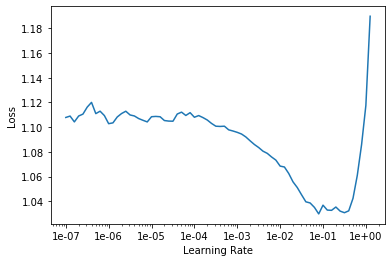

In [43]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

### Carefully train the classifier
During classification, we gradually unfreeze layers as shown below. This helps us obtain a better classification accuracy than if we were to aggressively train all the layers at once. 

In [46]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.029337,0.967795,0.518797,00:01


In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-7,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.046042,0.950843,0.518797,00:01


In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.004202,0.901038,0.556391,00:02


In [49]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-7,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.924457,0.896669,0.548872,00:02
1,0.922685,0.892954,0.556391,00:02
2,0.919102,0.884767,0.563910,00:02
3,0.915355,0.884280,0.563910,00:02


### Cross-tabulate the predictions for each class
The below table shows the predicted classes for the topic in concern. The actual evaluation of the F1 score of the classification result is done at a later step.

In [50]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,42,16,11
1,20,24,1
2,7,3,9


## Evaluate the predicted results from the classifier (SemEval tweets only)
We read in the test dataset and store in a Pandas DataFrame as shown.

In [51]:
test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
test = test.drop(['ID'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

,Target,Tweet,Stance
0,Atheism,He who exalts himself shall be humbled; a...,UNKNOWN
1,Atheism,RT @prayerbullets: I remove Nehushtan -previou...,UNKNOWN
2,Atheism,@Brainman365 @heidtjj @BenjaminLives I have so...,UNKNOWN
3,Atheism,#God is utterly powerless without Human interv...,UNKNOWN
4,Atheism,@David_Cameron Miracles of #Multiculturalism...,UNKNOWN


Since we do not yet know the stance for the test set, it is marked as "UNKNOWN". 

### Filter the test data set based on topic we are classifying for

In [52]:
test_pred = test[['Target', 'Tweet']]
test_pred = test_pred.loc[test_pred['Target'] == topic]
test_pred.tail()

,Target,Tweet
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad..."
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....
672,Feminist Movement,@angerelle you disagree that people should str...
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...


### Apply the learner's ```predict``` method to produce our prediction

In [53]:
test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [54]:
test_pred.tail()

,Target,Tweet,Stance
669,Feminist Movement,@Maisie_Williams is our hero with her #LikeAGi...,FAVOR
670,Feminist Movement,"Rather be an ""ugly"" feminist then be these sad...",AGAINST
671,Feminist Movement,iamNovaah: RT ChrzOC: Bitches be running wild....,NONE
672,Feminist Movement,@angerelle you disagree that people should str...,AGAINST
673,Feminist Movement,#Rapeculture is basically a FABLE. It has almo...,AGAINST


### Output the predicted dataset to a text file for comparison with the gold reference

In [55]:
test_pred.to_csv(path/'eval'/'predicted.txt', sep='\t', index=True,
                 header=['Target', 'Tweet', 'Stance'], index_label='ID')

Once we have the predicted data, we use the *perl* script provided by the SemEval organizers to generate the F1 score. 

The evaluation script is in ```data/eval/``` and has the following usage:

    perl eval.pl gold_feminism.txt predicted.txt
    
    ============
    Results				 
    ============
    FAVOR     precision: 0.3265 recall: 0.5517 f-score: 0.4103
    AGAINST   precision: 0.7259 recall: 0.5355 f-score: 0.6164
    ------------
    Macro F: 0.5133

Using a relatively small input vocabulary from the Twitter training data, we do not do that well in the F-score for the "Feminist Movement" topic.  On trying out a similar approach for Tweets from the other topics (Atheism, Hillary Clinton, etc.), we still do not see an F-score of above 0.60 - this is well below the winning score by *MITRE* of 0.67.

To improve the score, some more fine-tuning is needed.

## 5.3 Train the Classifier: Augmented Vocabulary
Since the initial approach (despite multiple attempts at fine-tuning both the language model and the classifier) did not an F-score as high as *MITRE's* (which was ~0.67), it can be reasoned that this could be because the pre-trained language model did not generalize to Tweets specifically (since the language syntax of tweets are quite different than the Wikipedia text that the LSTMs were trained on). 

The provided training data of 2,800 Tweets can be augmented with the Kaggle [Twitter Sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140) of 1.6 million tweets. By fine-tuning the language model on this larger Twitter dataset, we might better learn the structure of Twitter conversations. 

**NOTE**: Since 1.6 million tweets is quite a large dataset and can add a significant number of unique, one-time-only words, in this notebook, we only sampled a subset of 200,000 from the original Sentiment140 dataset for the language model fine-tuning to save on language model fine-tuning time. It is possible that fine-tuning the language model with a larger subset of the augmentation vocabulary could further improve the language model fine-tuned results. 

In [58]:
path

PosixPath('data')

In [59]:
# Load Kaggle Twitter Dataset
kaggle = pd.read_csv(path/"training.1600000.processed.noemoticon.csv",header=None,encoding = "latin-1")
kaggle.columns = ['col1', 'col2',"col3","Stance","col5","Tweet"]
kaggle = kaggle[['Stance','Tweet']]
# Clean Data and Remove URL's from the tweets
kaggle['Tweet'] = kaggle['Tweet'].apply(clean_ascii)
kaggle['Tweet'] = kaggle['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
kaggle_sub = kaggle.sample(n=200000,random_state=77)
kaggle_sub = kaggle_sub.append(train, ignore_index=True)

In [61]:
# The Lines are commented out as this takes a long time to run
# Write train to csv
kaggle_sub.to_csv(path/'kaggle_train_sub_v2.csv', index=False, header=False)
twitter_lm = TextLMDataBunch.from_csv(path, 'kaggle_train_sub_v2.csv', min_freq=1)
twitter_lm.save()
twitter_lm.show_batch()

idx,text
0,"is success of women in world # semst xxbos my whole body hurts xxbos @digital_girl xxmaj well , i 'm signing off so goodnight xxbos xxmaj the ruins ! xxmaj god i love movie channels xxbos xxmaj just finish watching i am sam ... xxbos @dominicscott exciting was it xxbos @livefordesign xxup how xxup do xxup you xxup only xxup have xxup two xxup left ? ! i have 9"
1,"' xxmaj wayne was in the house too i could n't get a pic with him though ... xxbos @missmercyb \ o / xxmaj goal ! i am teh winz . xxmaj happy to make the smileys occur . xxbos @bosstycoonlz yea but that 's an old pic , she looks a lot different now ... she turned into such a beautiful women i miss her a xxup lot !"
2,"for u i guess ? xxup lol dts fine nice song . xxbos xxmaj so bummed that xxup @e xxrep 5 m 11 ca nt get on tonight . i miss you already and the rps were getting so good xxbos @svusmile no precal till xxmaj monday ! xxmaj prom prep xxbos @nhuhieuma ava ny c?ng ch ? c 3 mu nh ? ? : - / @gk2007 thui ,"
3,you like 2 laugh .. have a good time .. follow me .. its just that simple xxbos yeayyy going out with @eyesights xxbos i am leaving to xxup la at 4 am and i have nt even fallen to sleep yet xxup fuck xxup it ill sleep on the ride down there lol xxbos @fair_carlien not really . a bit lang . haha . did you know may mcfly
4,inspiration ! now as before . c you on tv soon ! xxbos ight heading home . been with tray all day chillin xxbos @kellneriner88 xxmaj quite random la teringat that dude . xxup lol . i do n't know what 's for dinner . xxmaj dah la i tgh2 stress ni cepat lapar . xxmaj haih . xxbos is laughed at for wanting to watch xxmaj terminator xxmaj salvation


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


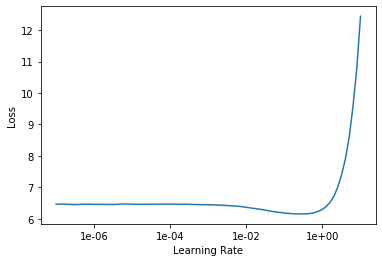

In [65]:
#learn_twitter = language_model_learner(twitter_lm, pretrained_model=URLs.WT103_1, drop_mult=0.1)
learn_twitter = language_model_learner(twitter_lm, AWD_LSTM, drop_mult=0.1)
learn_twitter.lr_find(start_lr=1e-8, end_lr=1e2)
learn_twitter.recorder.plot()

In [66]:
#learn_twitter = language_model_learner(twitter_lm, pretrained_model=URLs.WT103_1,drop_mult=0.5)
learn_twitter = language_model_learner(twitter_lm, AWD_LSTM, drop_mult=0.5)
learn_twitter.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.088380,4.753507,0.195637,02:19


In [67]:
learn_twitter.unfreeze()
learn_twitter.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.716984,4.461825,0.232094,02:36
1,4.526239,4.304780,0.243075,02:37
2,4.383340,4.218008,0.250425,02:37
3,4.245416,4.175201,0.254571,02:37
4,4.101486,4.162943,0.257551,02:39
5,3.973529,4.170428,0.258487,02:42
6,3.826269,4.191282,0.256137,02:38
7,3.735151,4.212798,0.254749,02:37
8,3.654156,4.230677,0.254264,02:38
9,3.618005,4.239648,0.253882,02:40


In [68]:
# Save the fine-tuned encoder (Uncomment the line given below)
learn_twitter.save_encoder('ft_enc_kaggle_v1')

### Load Vocabulary
This assumes that we have a fine-tuned language model's numericalized vocabulary ```vocab.pkl``` in the same directory as the notebook.

In [69]:
#Save the Vocab to a Pickle file for later use
pickle.dump(twitter_lm.train_ds.vocab, open(f'vocab.pkl','wb'))
vocab_load = pickle.load(open('vocab.pkl', 'rb'))

Various values of momentum, dropout and learning rates were tried to find the best values of these parameters. The below parameters are applied in a for loop to train on each topic one by one, and then appending the predictions to a common file for comparison with the gold reference.

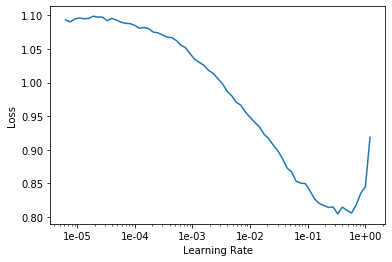

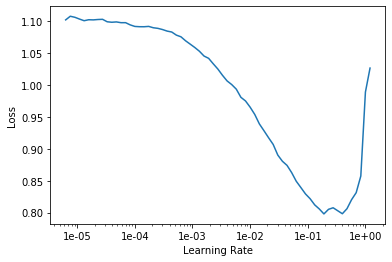

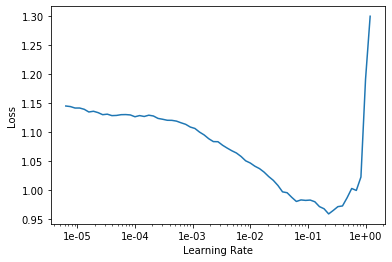

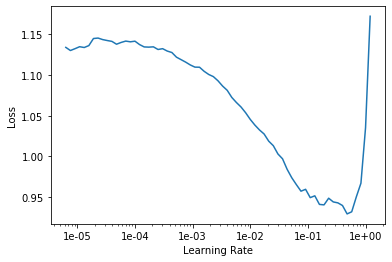

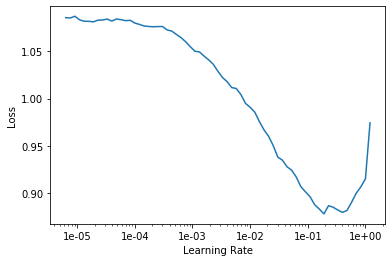

In [71]:
for topic in train_orig.Target.unique():
    print("Topic: ",topic)
    #learn_twitter=learn_twitter_org
        # Get only those tweets that pertain to a single topic in the training data
    train_topic = train.loc[train_orig['Target'] == topic]
    # Write train to csv
    train_topic.to_csv(path/'train_topic.csv', index=False, header=False)
    # Classifier model data
    data_clas = TextClasDataBunch.from_csv(path, 'train_topic.csv', vocab=vocab_load, min_freq=7, bs=64)
    data_clas.save()
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
    learn.load_encoder('ft_enc_kaggle_v1')
    learn.freeze()

    #Find Optimum Learning Rate
    learn.lr_find(start_lr=1e-6, end_lr=1e2)
    learn.recorder.plot()

    #Train the Classifier by Gradually Unfreezing the Layers
    learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))
    #Unfreeze Layer
    learn.freeze_to(-2)
    learn.fit_one_cycle(3, slice(1e-4,1e-2), moms=(0.8,0.7))
    #Unfreeze Layer
    learn.freeze_to(-3)
    learn.fit_one_cycle(3, slice(1e-5,5e-3), moms=(0.8,0.7))
    #Unfreeze All Layers
    learn.unfreeze()
    learn.fit_one_cycle(3, slice(1e-5,1e-3), moms=(0.8,0.7))
    # get predictions
    preds, targets = learn.get_preds()
    predictions = np.argmax(preds, axis=1)
    pd.crosstab(predictions, targets)

    test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
    # test = test.drop(['ID'], axis=1)
    # test['Tweet'] = test['Tweet'].apply(clean_ascii)
    test.head()

    test_pred = test[['Target', 'Tweet']]
    test_pred = test_pred.loc[test_pred['Target'] == topic]
    test_pred.tail()

    test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
    file_to_save="predicted_"+str(topic.replace(" ", "_"))+".txt"
    test_pred.to_csv(path/'eval'/file_to_save, sep='\t', index=True,
                     header=['Target', 'Tweet', 'Stance'], index_label='ID')
    if(topic=="Atheism"):
        preds_document=test_pred
    else:
        preds_document=preds_document.append(test_pred, ignore_index=True)

### Output the predicted dataset to a text file for comparison with the gold reference

In [72]:
preds_document.to_csv(path/'eval'/'predicted.txt', sep='\t', index=True,
                      header=['Target', 'Tweet', 'Stance'], index_label='ID')

The evaluation script is in ```data/eval/``` is run with the following command:

    perl eval.py gold.txt predicted.txt

    ============
    Results                          
    ============
    FAVOR     precision: 0.5842 recall: 0.5362 f-score: 0.5592
    AGAINST   precision: 0.7404 recall: 0.7301 f-score: 0.7352
    ------------
    Macro F: 0.6472

Based on the above result, we can see that augmenting the training data with additional domain-specific data (i.e., Tweets) helps us obtain better F-scores for the stance classification task.

This result is much closer to the winning result by *MITRE* (of 0.67). The improvement can be largely attributed to the language model fine-tuning step, where we augmented the language model parameters with the tokenized form of a much larger Tweet vocabulary (of 200,000 Tweets downloaded from Kaggle). It can be reasoned that using an even larger Tweet vocabulary (say a million words) could result in a further improvement. However, this would also significantly increase the training time during fine-tuning. In addition to vocabulary augmentation, more extensive hyperparameter tuning and careful classifier fine-tuning could result in further gains. 

# 6. Conclusions

This notebook showed a training and classification pipeline for a PyTorch-based framework (*ULMFit*) for evaluating stance of Tweets towards a particular topic. It appears that with some basic data cleaning and augmentation with additional Twitter language data, the transfer learning approach using *ULMFit* can provide good classification accuracy F-scores (compared with the winning results from the SemEval 2016 winning team *MITRE*). 

The main benefit of using *ULMFit* is that it can perform classifier re-training with a *very limited amount of data* (fewer than 500 Tweets per topic in this dataset). However, since Twitter data is of a very different distribution from the pre-trained language model, the language model fine-tuning step is rather expensive (and can take significant time even on GPU). Once the language model is fine-tuned adequately, the classifier can perform per-topic classification relatively easily and with a reasonable level of accuracy comparable with the best score by *MITRE*. 

We can likely further improve the classification accuracy across all topics with the below steps:

1.  Augment the language model vocabulary with a larger subset of Twitter Sentiment140 dataset to improve the model's domain understanding of Tweet syntax

2.  Perform additional fine-tuning on the training hyperparameters in both the language model fune-tuning and the classifier fine-tuning stages. 

3.  Plug in a pre-trained language model that was trained on a large Twitter dataset (if such a model becomes available in the future!)

Tweets are sufficiently different from typical language data used to generate pre-trained language models, and  hence are an interesting usecase for analyzing the effectiveness of transfer learning techniques. It will be interesting to see how transfer learning techniques for NLP tasks evolve with time.